# 4.4

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

## Load Data

In [2]:
# Get train data data

train_1 = pd.read_csv('data/train_1.csv')
train_2 = pd.read_csv('data/train_2.csv')

train = pd.merge(train_1, train_2, on="ID")

# Get test data data

predict_1 = pd.read_csv('data/predict_1.csv')
predict_2 = pd.read_csv('data/predict_2.csv')

predict = pd.merge(predict_1, predict_2, on="ID")

In [3]:
# Function that shows basin information of the data frame:

def show_df(df):
    print("Data Frame:\n\n", df.head())
    print("\nShape: ",df.shape)
    print("\nNulls:\n", df.isnull().values.sum())
    print("\nDuplicados:\n", df.duplicated().values.sum())
    print("\nTypes:")
    for column in df:
        print("\t", '{:<20}'.format(column), '{:>8}'.format(str(df[column].dtype)))

In [4]:
show_df(train)

Data Frame:

    ID    zn  chas     rm     dis  rad  tax  medv     crim  indus    nox   age  \
0   1  18.0     0  6.575  4.0900    1  296  24.0  0.00632   2.31  0.538  65.2   
1   2   0.0     0  6.421  4.9671    2  242  21.6  0.02731   7.07  0.469  78.9   
2   4   0.0     0  6.998  6.0622    3  222  33.4  0.03237   2.18  0.458  45.8   
3   5   0.0     0  7.147  6.0622    3  222  36.2  0.06905   2.18  0.458  54.2   
4   7  12.5     0  6.012  5.5605    5  311  22.9  0.08829   7.87  0.524  66.6   

   ptratio   black  lstat  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     18.7  394.63   2.94  
3     18.7  396.90   5.33  
4     15.2  395.60  12.43  

Shape:  (333, 15)

Nulls:
 0

Duplicados:
 0

Types:
	 ID                      int64
	 zn                    float64
	 chas                    int64
	 rm                    float64
	 dis                   float64
	 rad                     int64
	 tax                     int64
	 medv                  float64
	 crim               

## Clean Data

Vemos que no hay ni elementos duplicados ni nulos. Vamos a ver si hay outliers.

In [5]:
# Function that shows basic statistical quantities of each column of the DataFrame

def statistics(df):
    print('{:<23}'.format('Column'), '{:<23}'.format('Mean'), '{:<23}'.format('Std'), '{:<10}'.format('Median'), '{:<10}'.format('Min'), '{:<10}'.format('Max'),'\n')
    for col in df:
        print('{:<23}'.format(col), '{:<23}'.format(df[col].mean()), '{:<23}'.format(df[col].std()), '{:<10}'.format(df[col].median()), '{:<10}'.format(df[col].min()), '{:<10}'.format(df[col].max()))

In [6]:
# Check the statistics to find if there are outliers or unbalanced columns
statistics(train)

Column                  Mean                    Std                     Median     Min        Max        

ID                      250.95195195195194      147.85943780185968      244.0      1          506       
zn                      10.68918918918919       22.674761796618185      0.0        0.0        100.0     
chas                    0.06006006006006006     0.23795564281644857     0.0        0          1         
rm                      6.265618618618616       0.7039515757334481      6.202      3.561      8.725     
dis                     3.7099336336336335      1.9811230514407006      3.0923     1.1296     10.7103   
rad                     9.633633633633634       8.742174349631075       5.0        1          24        
tax                     409.27927927927925      170.84198846058226      330.0      188        711       
medv                    22.768768768768783      9.17346802731542        21.6       5.0        50.0      
crim                    3.3603414714714708      7.352


--------------------  ID  --------------------



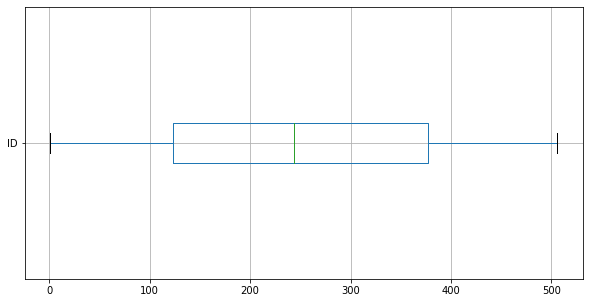


--------------------  zn  --------------------



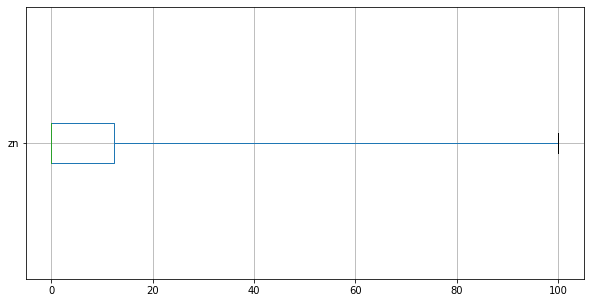


--------------------  chas  --------------------



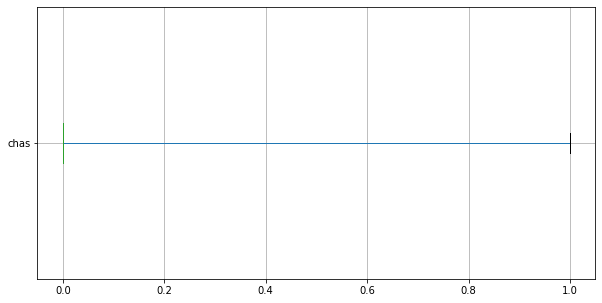


--------------------  rm  --------------------



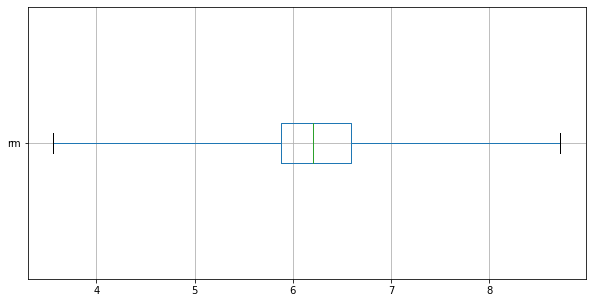


--------------------  dis  --------------------



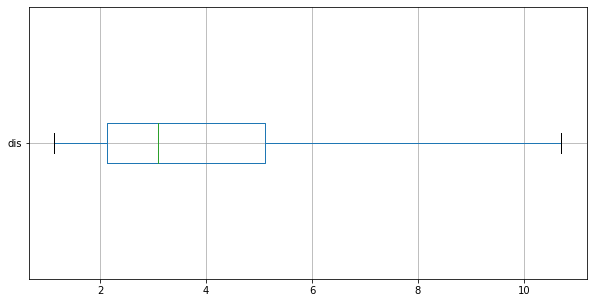


--------------------  rad  --------------------



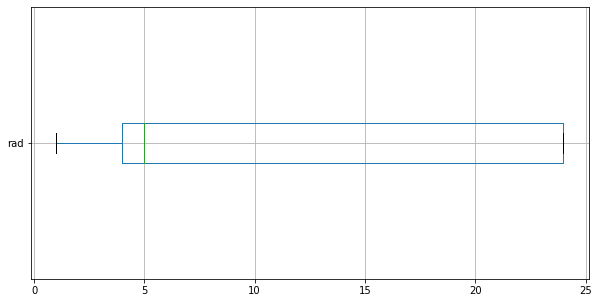


--------------------  tax  --------------------



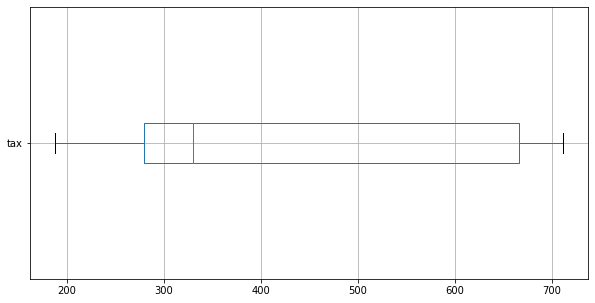


--------------------  medv  --------------------



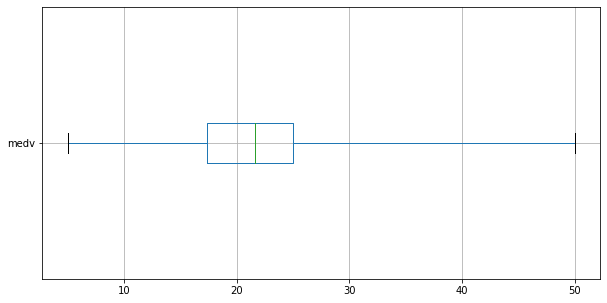


--------------------  crim  --------------------



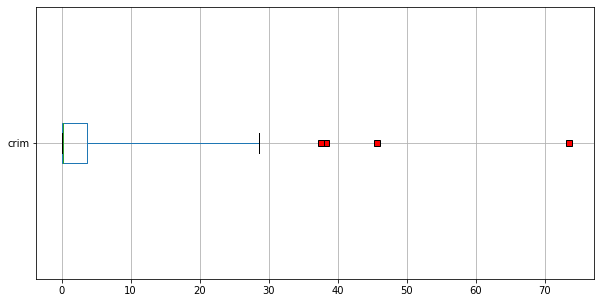


--------------------  indus  --------------------



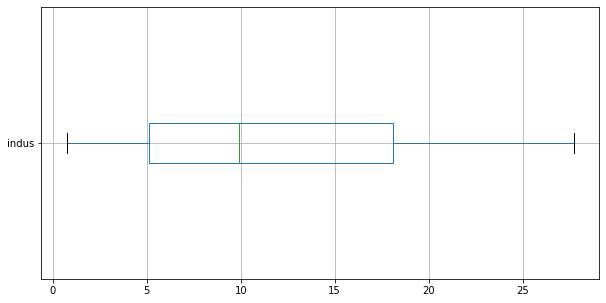


--------------------  nox  --------------------



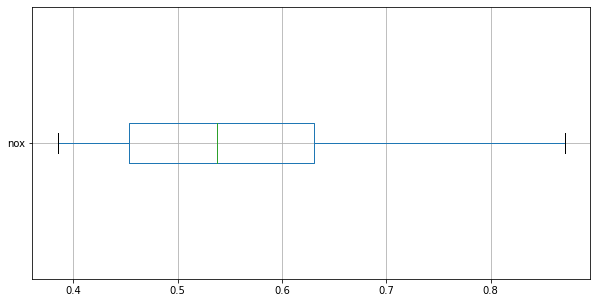


--------------------  age  --------------------



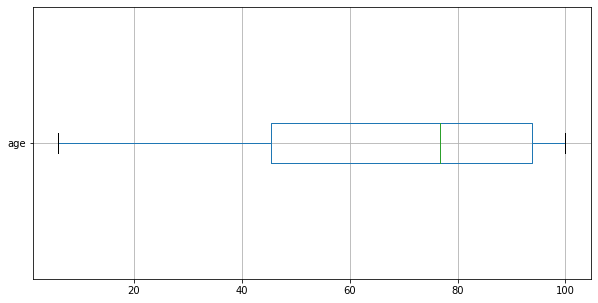


--------------------  ptratio  --------------------



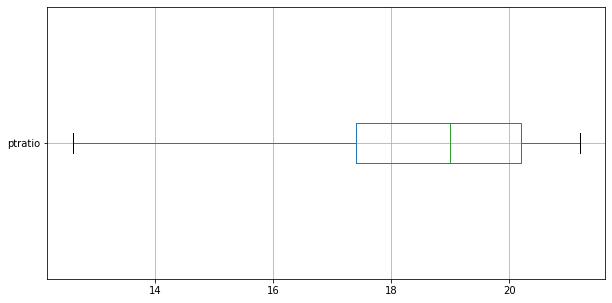


--------------------  black  --------------------



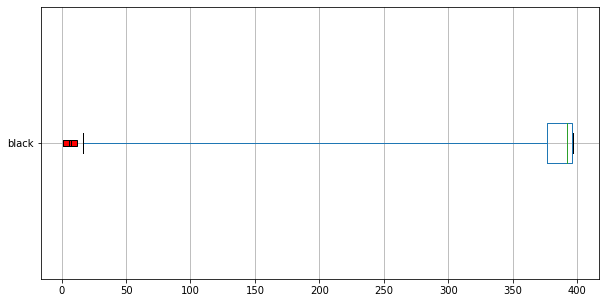


--------------------  lstat  --------------------



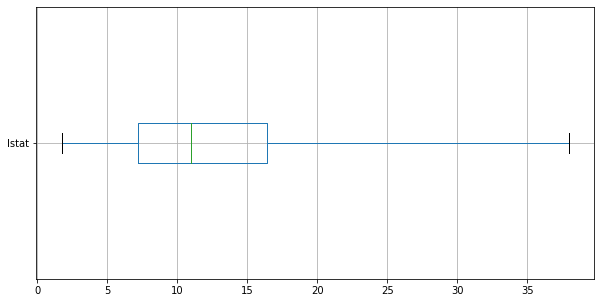

In [7]:
# We use matplotlib to print the boxplots ans identify what sigma will clean the best our model.
# We usualy use 3 sigmas but we don't want to discart to much data nor too little.

for column in train:
    print("\n-------------------- ", column, " --------------------\n")
    
    fig = plt.figure(figsize = (10,5))
    
    mean = np.mean(train[column])
    std = np.std(train[column])
    whis = np.interp([mean-4*std, mean+4*std], np.sort(train[column]), np.linspace(0,1,train[column].size)) * 100
    
    red_square = dict(markerfacecolor = 'r', marker = 's')
    train.boxplot([column], whis = whis, vert = False, flierprops = red_square)
    plt.show()

Using a 4 sigma boxplot we can see that the only outliers are in crime and black, and the ones from black are not that far from the thresh hold, but we might clean them as they might affect our model.

* We use 4 sigma deviation instead of 3 which is more usual because of the lack of data, we only have 333 observations to train and it's better not discart too many

In [8]:
# Function to discard the values that are greater than sigma times the std
def clean_outliers(df, sigma):
    new = df.copy()
    for col in new:
        new = new[(np.abs(stats.zscore(new[col])) < sigma)]
  
    return new

In [9]:
train_clean = clean_outliers(train, 4)
train_clean.shape

(323, 15)

We have discarted only 10 values, if we would have used 3 sigmas we would have discarted 74 values insted.

Lets now see if there is any correlation between variables that makes us discard any.

<AxesSubplot:>

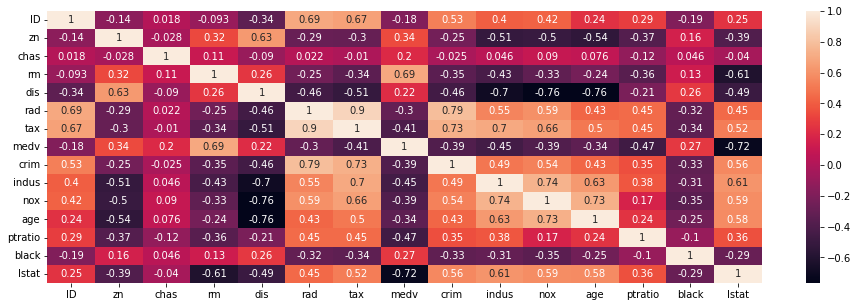

In [10]:
# Plot the correlation matrix:

plt.figure(figsize = (16, 5))
sns.heatmap(train_clean.corr(), annot = True)

As we can see rad is highly correlated with tax, this makes sence as the more taxes people pay the better the communications wiht the roads will be. So as they are highly correlated and the relation seems causal, we can discard the rad varaible.

We will drop ID as it's not relevant for the model.

In [11]:
train_final = train_clean.drop(['ID', 'rad'], axis = 1)
train_final.describe()

,zn,chas,rm,dis,tax,medv,crim,indus,nox,age,ptratio,black,lstat
count,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000,323.000000
mean,11.020124,0.061920,6.279830,3.762297,401.331269,23.163777,2.643375,11.082755,0.553359,67.522291,18.393808,368.756533,12.178916
std,22.944581,0.241383,0.704402,1.987314,167.282069,9.005789,5.013281,7.000809,0.114456,28.212492,2.162374,66.606344,6.798312
min,0.000000,0.000000,3.561000,1.129600,188.000000,5.600000,0.006320,0.740000,0.385000,6.000000,12.600000,43.060000,1.730000
25%,0.000000,0.000000,5.885500,2.169150,277.000000,17.800000,0.073735,5.040000,0.453000,44.350000,17.150000,377.705000,6.925000
50%,0.000000,0.000000,6.211000,3.132300,329.000000,21.800000,0.241030,8.560000,0.532000,76.500000,18.700000,392.300000,10.590000
75%,12.500000,0.000000,6.617000,5.164950,666.000000,25.150000,2.542505,18.100000,0.624000,93.350000,20.200000,396.290000,15.890000
max,100.000000,1.000000,8.725000,10.710300,711.000000,50.000000,28.655800,27.740000,0.871000,100.000000,21.200000,396.900000,37.970000


We discart the rad column in the predict data, for now we don't discart the outliers, in case we dont get good results we will try to clean them and see if it matters.

In [12]:
predict_final = predict.drop(['ID', 'rad'], axis = 1)
predict_final.describe()

,zn,chas,rm,dis,tax,crim,indus,nox,age,ptratio,black,lstat
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
mean,12.661850,0.086705,6.321237,3.958865,406.231214,4.100862,10.835145,0.549981,69.245665,18.469942,351.299711,12.917977
std,24.536277,0.282219,0.700621,2.324131,164.480626,10.607761,6.596488,0.117826,28.248244,2.196196,99.781464,7.293408
min,0.000000,0.000000,4.138000,1.178100,187.000000,0.013810,0.460000,0.392000,2.900000,12.600000,0.320000,1.920000
25%,0.000000,0.000000,5.895000,2.010700,279.000000,0.082210,5.320000,0.447000,42.800000,17.000000,371.720000,6.870000
50%,0.000000,0.000000,6.223000,3.421100,330.000000,0.251990,8.560000,0.538000,79.200000,19.100000,390.070000,12.120000
75%,20.000000,0.000000,6.674000,5.400700,666.000000,3.673670,18.100000,0.624000,94.600000,20.200000,396.060000,17.210000
max,95.000000,1.000000,8.780000,12.126500,711.000000,88.976200,27.740000,0.871000,100.000000,22.000000,396.900000,34.370000


## Model

### Set train data and test data

In [13]:
# Set train data
y = train_final.pop('medv')
X = train_final

# Split the data 80% for train and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

# Set test data
X_predict = predict_final

### Normalization

In [14]:
# We use SatandardScaler from sklearn to normalize the data

# Initialize the normalizer and train it with train data
scaler_X = StandardScaler()
scaler_X = scaler_X.fit(X_train)

# Normalize the train data
scaled_X = scaler_X.transform(X_train)

# Normalize the test data
scaled_X_test = scaler_X.transform(X_test)

# Normalize the predict data
scaled_X_predict = scaler_X.transform(X_predict)

### Random Forest Regression

In [15]:
# Define the model
rf = RandomForestRegressor(max_depth = 10)

# Train the model
rf = rf.fit(scaled_X, y_train)

In [16]:
# Results
rf_score = rf.score(scaled_X_test, y_test)
print(rf_score)

0.8159763158139537


### Sklearn Neural Network

In [17]:
# Define the model
sk_mlp = MLPRegressor(hidden_layer_sizes=(60, 120, 120, 60), max_iter = 10000)

# Train the model
sk_mlp = sk_mlp.fit(scaled_X, y_train)

In [18]:
# Results
sk_mlp_score = sk_mlp.score(scaled_X_test, y_test)
print(sk_mlp_score)

0.8225113720063122


### Pytorch

In [19]:
class MLP(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(12, 60),
            nn.ReLU(),
            nn.Linear(60, 120),
            nn.ReLU(),
            nn.Linear(120, 120),
            nn.ReLU(),
            nn.Linear(120, 60),
            nn.ReLU(),
            nn.Linear(60, 1)
        )


    def forward(self, x):
        '''
          Forward pass
        '''
        return self.layers(x)

In [20]:
# Transform the data to numpy array of type float
features_train = np.array(scaled_X).astype('float32')
targets_train = np.array(y_train).astype('float32')

features_test = np.array(scaled_X_test).astype('float32')
targets_test = np.array(y_test).astype('float32')

# Create feature and targets tensor for train set.
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train)

featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test)

# batch_size, epoch and iteration
batch_size = len(features_train)
n_iters = 50000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain, targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest, targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = True)

# Initialize the MLP
torch_mlp = MLP()

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(torch_mlp.parameters(), lr=1e-5)

In [21]:
# Run the training loop
count = 0
loss_list = []
iteration_list = []

for epoch in range(num_epochs):
    # Iterate over the DataLoader for training data
    for i, (inputs, targets) in enumerate(train_loader):

        inputs = Variable(inputs)
        targets = Variable(targets.reshape(-1, 1))

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = torch_mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()
        
        count += 1
        
        if count % 500 == 0:
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            
            # Print Loss
            if count % 5000 == 0:
                print('Iteration: {}  Loss: {}'.format(count, loss.data))

Iteration: 5000  Loss: 23.31366539001465
Iteration: 10000  Loss: 8.666630744934082
Iteration: 15000  Loss: 3.1433141231536865
Iteration: 20000  Loss: 0.32897892594337463
Iteration: 25000  Loss: 0.017047764733433723
Iteration: 30000  Loss: 0.0020577190443873405
Iteration: 35000  Loss: 0.0006877155974507332
Iteration: 40000  Loss: 0.0003352299681864679
Iteration: 45000  Loss: 0.0001815626019379124
Iteration: 50000  Loss: 5.2419843996176496e-05


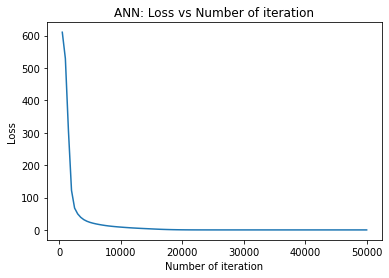

In [22]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

In [23]:
def r2_score(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [24]:
# Results
inputs = Variable(featuresTest)
targets = Variable(targetsTest.reshape(-1, 1))
outputs = torch_mlp(inputs)

torch_mlp_score = r2_score(outputs, targets).item()

print("R2 Score : ", r2_score(outputs, targets).item())
print("MSE : ", loss_function(outputs, targets).item())

R2 Score :  0.7785812020301819
MSE :  15.488675117492676


## Predictions

In [25]:
rf_predictions = rf.predict(scaled_X_predict)
sk_mlp_predictions = sk_mlp.predict(scaled_X_predict)

# Transform the data to numpy array of type float
features_predict = np.array(scaled_X_predict).astype('float32')

# Create feature tensor for predict set.
featuresPredict = torch.from_numpy(features_predict)
inputs = Variable(featuresPredict)

# Torch predictions
torch_mlp_predictions = torch_mlp(inputs).detach().numpy().reshape(1, -1)[0]

To produce the final prediction as we can't ensure that any model is better than other we will use a weighted mean of them to generate a more robust model.

In [26]:
final_predicction = ((rf_predictions * rf_score) 
                     + (sk_mlp_predictions * sk_mlp_score) 
                     + (torch_mlp_predictions * torch_mlp_score)) / (rf_score + sk_mlp_score + torch_mlp_score)
print(final_predicction)

[33.7367783  25.14589568 17.40738905 18.04194713 18.2176331  19.92982341
 18.81300193 16.89359351 15.30066561 18.49134513 17.38440461 21.27652626
 17.18158867 15.27828174 21.58534752 23.80835585 22.60131251 30.74895392
 17.26722475 26.10473213 21.41091743 25.65397607 21.45620239 21.06861212
 20.62286626 20.59712876 23.59206471 24.24525749 24.36468743 27.05144944
 42.12087434 43.94041947 33.82679404 19.45401802 16.87392722 22.41120422
 16.40044733 14.096079   18.84075563 21.10721568 15.63673095 18.36811321
 18.68520159 17.10572458 15.66195251 15.24416573 13.81286773 15.27922068
 18.59660929 17.43387348 17.25359624 35.31925178 46.1758438  21.9037915
 27.71411508 26.84211502 31.41725241 47.79651548 40.02890853 36.86253978
 30.60756222 45.04725715 20.7787738  17.49347147 18.33826656 24.29895666
 25.73695604 31.20100133 16.48938633 22.22841327 28.2861776  47.49822972
 33.20653737 31.92162428 24.88189574 27.08988261 18.32770883 19.41583611
 22.52169794 29.92155848 22.07384116 20.06896748 41.

## Conclusions

With such little amount of data the models are highly dependent on the data split, the results vary significantly on depending on how the data have spliten and that producces a quite noisy models.

In general the Random Forest have produced better results, that the MultiLayer Perceptron models, and the sklear preceptron gets better results than the torch model mainly because it uses more hyperparameters to refine the learning process.

Finally to generate a more robust model we combine all of them via a weighted mean to generate the predictions.